## Importing Packages

In [6]:
# Importing (using/include) packages and files needed for the code to run 
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [7]:
# The initial topography setup follows the following:
# y = A*sin[k(x-b)]+c 
# |A| is the amplitude 
# k is the wave number (k=2π/wavelength)
# The period is 2π/k 
# The horizontal shift is b 
# The vertical shift is c 


function initial_ice_depth(x::Float64)
    w = 90000.0
#     w1 = 90000.0
#     w2 = 10000.0
#     w3 = 100000.0 
#     w4 = 200000.0
#     w5 = 300000.0
#     w6 = 400000.0
#     w7 = 500000.0
    A = 0.1*90000.0
    k = (2*pi)/w
    b = 0.0
    c = 0.5*90000.0
    return (A)*(sin(k*(x-b)))+(c)
end

function initial_surface_depth(x::Float64)
     return 1e4
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else 
        ice_vis = ice_vis
    end 
    return ice_vis
end


# # Creating a function to assign viscosity if eta is not constant
# function compute_variable_eta(markers::Markers,materials::Materials)
#     t_icy = zeros(1,markers.nmark)
#     eta_i = zeros(1,markers.nmark)
#     for i in 1:markers.nmark
#         mx = markers.x[1,i]
#         my = markers.x[2,i]
#         h = initial_ice_depth(mx)
#         hsurf = initial_surface_depth(mx)
#         if my < h
#             t_icy[i] = 100.0+((273.0-100.0)/(h-hsurf))*(my-hsurf)
#             eta_i[i] = (1e15)*exp((Q*(273.0-t_icy[i]))/(R_cont*(273.0*t_icy[i])))
#         end
#     end 
#     return t_icy,eta_i
# end


ice_viscosity (generic function with 1 method)

# Material Setup

In [8]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1.0],[0.5610,2.22,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_viscosity!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity( markers.scalars[T,i] )
        end
    end
end


function update_marker_density!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark                
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
    end
end


function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        hsurf = initial_surface_depth(mx)
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]  
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]  
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3] 
        end
    end 
    # end loop over markers
    update_marker_viscosity!(markers,materials)
    update_marker_density!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# Model Setup

In [9]:
# function run(nstep::Int64)
    nstep=1000
    nx = 101
    ny = 101
    W = 90000.0
    H = 90000.0
    gx = 0.0
    gy = 1.3

    
#     Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbctype = [1,-1,1,1]
#     Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    Tbcval = [273.0,0.0,100.0,273.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)

    max_time::Int64=nstep
    max_step::Int64=-1
    max_time::Float64 = max_time == nstep ? typemax(Float64) : max_time
    max_step::Int64 = max_step == -1 ? typemax(Int64) : max_step



    # Setting up inital model schematic
    i_air_ice_interface = zeros(Float64,grid.nx+1)
    i_ocean_ice_interface = zeros(Float64,grid.nx+1)
    # Transfer materials to nodes
    i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
    function get_i_interface(grid::CartesianGrid,mat,contour_value)
        i_interface_position = zeros(Float64,grid.nx+1);
        for j in 1:grid.nx+1
            i = 1
            while i <= grid.ny
                if i_mat[i,j] == contour_value
                    i_interface_position[j] = grid.yc[j]
                    break
                elseif i_mat[i+1,j] < contour_value
                    # interface is located within this cell.
                    i_interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(i_mat[i+1,j]-i_mat[i,j])*(contour_value-i_mat[i,j])
                    break
                end
                i = i+1
            end
        end
        return i_interface_position
    end
    i_air_ice_interface = get_i_interface(grid,i_mat,2.5)
    i_ocean_ice_interface = get_i_interface(grid,i_mat,1.5)


    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    
    time = 0.0
    iout=0
    last_plot = 0.0
    dt = 1e10

    rho_c = nothing
    rho_vx = nothing 
    rho_vy = nothing 
    alpha = nothing 
    Hr = nothing 
    Cp_c = nothing 
    eta_s = nothing 
    eta_n = nothing 
    vxc = nothing 
    vyc = nothing 
    T = nothing 
    dTmax = nothing 
    dTemp = nothing 
    Tnew = nothing 
    Tlast = nothing 
 
#     local rho_c 
#     local rho_vx
#     local rho_vy
#     local alpha
#     local Hr
#     local Cp_c
#     local eta_s
#     local eta_n
#     local vxc
#     local vyc
#     local T
#     local dt
#     local dTmax
#     local dTemp
#     local Tnew
#     local Tlast

    itime = 1

    terminate = false
    while !terminate
    output_dir = "test"
#     for itime in 1:nstep
        # 0. update the viscosity and the density on the markers
        update_marker_viscosity!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic");
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 
       
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s).*0       
        H = (adiabatic_heating .+ shear_heating .+ Hr)
   
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)
   
        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer = 1
        for titer=1:2
            # assemble and solve the energy equation
#             println("Trying with timestep ",dt/3.15e7/1e6," Myr")
            println("Trying with timestep ",dt," Seconds")
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))          
#             println("dTmax=",dTmax," dt=",dt/3.15e7/1e6," Myr")
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node
    
        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")
    
        # Checking Termination Criteria, time is in Myr
        if time >= max_time || itime >= max_step
            terminate = true
        end    

        if time == 0.0 || time - last_plot >= plot_interval  || mod(itime,100) == 0
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)
            visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end
    
#         println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))            
        # Moving the markers and advancing to the next timestep
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        itime += 1
#         println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
        println("Finished Step ",itime," time=",time," Seconds")
    end
    return grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time
# end 
# @time grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time = run(1)

figure()
scatter(markers.x[1,:],markers.x[2,:],c="b",s=0.1)
show()

Creating Markers...
  0.080379 seconds (74.51 k allocations: 37.551 MiB, 87.90% compilation time)
Initial condition...
  0.086682 seconds (1.72 M allocations: 27.871 MiB)
Trying with timestep 1.3044417700875893e9 Seconds
dTmax=156.77663052215843 dt=4.141084984405045e-5 Myr
Trying with timestep 8.320384012228294e7 Seconds
dTmax=155.6846249357228 dt=2.641391749913744e-6 Myr
Writing visualization fle test/viz.0000.vtr
  0.003588 seconds (2 allocations: 5.493 MiB)
Finished Step 2 time=5.344383888687476e6 Seconds
Trying with timestep 6.41326066642497e6 Seconds
dTmax=16.85962820221158 dt=2.035955767119038e-7 Myr
Trying with timestep 3.8039158334367676e6 Seconds
dTmax=16.62344486393971 dt=1.2075923280751645e-7 Myr
Finished Step 3 time=7.632667613614062e6 Seconds
Trying with timestep 2.7459404699119027e6 Seconds
dTmax=5.770519037209198 dt=8.71727133305366e-8 Myr
Finished Step 4 time=1.0378608083525965e7 Seconds
Trying with timestep 3.295128563894283e6 Seconds
dTmax=5.142665218245838 dt=1.04607

Trying with timestep 2.2061542754125047e9 Seconds
dTmax=5.187811063044819 dt=7.003664366388904e-5 Myr
Finished Step 53 time=3.831763417023232e10 Seconds
Trying with timestep 2.2421819882193856e9 Seconds
dTmax=5.187101539759908 dt=7.11803805783932e-5 Myr
Finished Step 54 time=4.0559816158451706e10 Seconds
Trying with timestep 2.273270545957112e9 Seconds
dTmax=5.1862982590390345 dt=7.21673189192734e-5 Myr
Finished Step 55 time=4.283308670440882e10 Seconds
Trying with timestep 2.3089967586298766e9 Seconds
dTmax=5.185072104824172 dt=7.330148440094847e-5 Myr
Finished Step 56 time=4.51420834630387e10 Seconds
Trying with timestep 2.351773966032567e9 Seconds
dTmax=5.183784051169084 dt=7.465949098516086e-5 Myr
Finished Step 57 time=4.7493857429071266e10 Seconds
Trying with timestep 2.401540401640903e9 Seconds
dTmax=5.182750619947967 dt=7.623937782986994e-5 Myr
Finished Step 58 time=4.9895397830712166e10 Seconds
Trying with timestep 2.4534167866599197e9 Seconds
dTmax=5.182045012672802 dt=7.78862

Trying with timestep 2.9839319141054516e9 Seconds
dTmax=5.193185665452205 dt=9.472799727318893e-5 Myr
Finished Step 106 time=2.306222861220449e11 Seconds
Trying with timestep 3.580718296926542e9 Seconds
dTmax=5.1947077346419235 dt=0.00011367359672782672 Myr
Finished Step 107 time=2.3420300441897144e11 Seconds
Trying with timestep 4.29686195631185e9 Seconds
dTmax=5.201849509102374 dt=0.00013640831607339207 Myr
Finished Step 108 time=2.384998663752833e11 Seconds
Trying with timestep 5.15623434757422e9 Seconds
dTmax=5.2081810696844855 dt=0.0001636899792880705 Myr
Finished Step 109 time=2.436561007228575e11 Seconds
Trying with timestep 6.187481217089064e9 Seconds
dTmax=5.217940935681526 dt=0.00019642797514568457 Myr
Finished Step 110 time=2.4984358193994656e11 Seconds
Trying with timestep 7.424977460506876e9 Seconds
dTmax=5.224220884042779 dt=0.00023571357017482144 Myr
Finished Step 111 time=2.5726855940045343e11 Seconds
Trying with timestep 8.789898876510252e9 Seconds
dTmax=5.234882651007

Trying with timestep 2.3074129482270935e10 Seconds
dTmax=5.3063348063001 dt=0.0007325120470562201 Myr
Finished Step 159 time=7.157690286214734e11 Seconds
Trying with timestep 2.3976875259775276e10 Seconds
dTmax=5.268057572527738 dt=0.0007611706431674691 Myr
Finished Step 160 time=7.397459038812487e11 Seconds
Trying with timestep 2.494917637718164e10 Seconds
dTmax=5.2305895597878305 dt=0.0007920373453073537 Myr
Finished Step 161 time=7.646950802584303e11 Seconds
Trying with timestep 2.60197749844026e10 Seconds
dTmax=5.19389573910982 dt=0.0008260246026794477 Myr
Finished Step 162 time=7.907148552428329e11 Seconds
Trying with timestep 2.714833519997738e10 Seconds
dTmax=5.163492219676158 dt=0.0008618519111103929 Myr
Finished Step 163 time=8.178631904428103e11 Seconds
Trying with timestep 2.8342470483129944e10 Seconds
dTmax=5.1438742368139 dt=0.0008997609677184109 Myr
Finished Step 164 time=8.462056609259402e11 Seconds
Trying with timestep 2.965445785569083e10 Seconds
dTmax=5.13106047547597

Finished Step 211 time=1.771642212936337e13 Seconds
Trying with timestep 3.1565307713477183e12 Seconds
dTmax=5.246577923458119 dt=0.10020732607453073 Myr
Finished Step 212 time=2.087295290071109e13 Seconds
Trying with timestep 3.7878369256172617e12 Seconds
dTmax=5.326695940931359 dt=0.12024879128943688 Myr
Finished Step 213 time=2.466078982632835e13 Seconds
Trying with timestep 4.545404310740714e12 Seconds
dTmax=5.298832694124201 dt=0.14429854954732424 Myr
Finished Step 214 time=2.9206194137069066e13 Seconds
Trying with timestep 5.454485172888856e12 Seconds
dTmax=5.2798846055110005 dt=0.1731582594567891 Myr
Finished Step 215 time=3.466067930995792e13 Seconds
Trying with timestep 6.545382207466628e12 Seconds
dTmax=5.200186698417639 dt=0.20778991134814692 Myr
Finished Step 216 time=4.120606151742455e13 Seconds
Trying with timestep 7.854458648959953e12 Seconds
dTmax=5.118381861089688 dt=0.2493478936177763 Myr
Writing visualization fle test/viz.0003.vtr
  0.003884 seconds (2 allocations: 5

Writing visualization fle test/viz.0033.vtr
  0.003288 seconds (2 allocations: 5.493 MiB)
Finished Step 252 time=1.0527974408247082e15 Seconds
Trying with timestep 3.15e13 Seconds
dTmax=4.633260526229009 dt=1.0 Myr
Writing visualization fle test/viz.0034.vtr
  0.003181 seconds (2 allocations: 5.493 MiB)
Finished Step 253 time=1.0842974408247082e15 Seconds
Trying with timestep 3.15e13 Seconds
dTmax=4.621509408936419 dt=1.0 Myr
Writing visualization fle test/viz.0035.vtr
  0.003358 seconds (2 allocations: 5.493 MiB)
Finished Step 254 time=1.1157974408247082e15 Seconds
Trying with timestep 3.15e13 Seconds
dTmax=4.6170562310612695 dt=1.0 Myr
Writing visualization fle test/viz.0036.vtr
  0.003979 seconds (2 allocations: 5.493 MiB)
Finished Step 255 time=1.1472974408247082e15 Seconds
Trying with timestep 3.15e13 Seconds
dTmax=4.617174908549174 dt=1.0 Myr
Writing visualization fle test/viz.0037.vtr
  0.004023 seconds (2 allocations: 5.493 MiB)
Finished Step 256 time=1.1787974408247082e15 Seco

LoadError: InterruptException:

# Plotting Routine 

In [6]:
# # Setting up route for saving plots to a folder
# function mk_output_dir()
#     timestamp = Dates.format(now(), "YYYYmmdd-HHMMSS")
#     dir_name = joinpath(@__DIR__, "Data", "run_$timestamp")
#     @assert !ispath(dir_name) 
#     mkpath(dir_name)
#     return dir_name
# end

mk_output_dir (generic function with 1 method)

# Initial Model Schematic and Profiles

The maximum total initial thickness of the icy shell is 44.1(km)
The average initial thickness of the icy shell is 35(km)
The initial amplitude is 9.03(km)

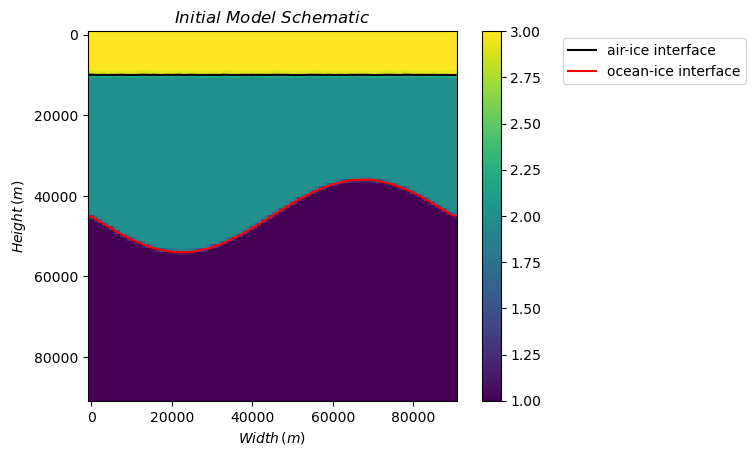

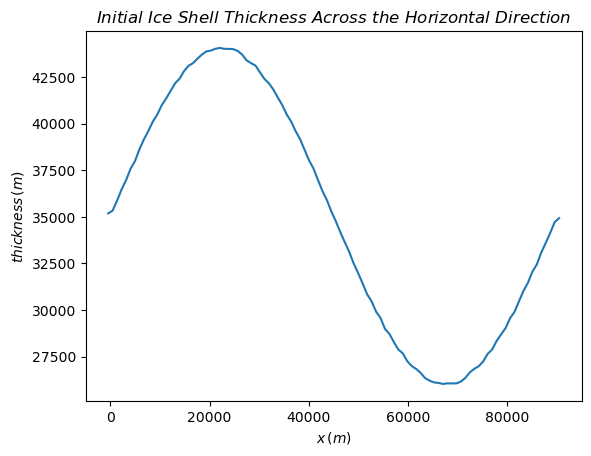

In [8]:
figure() 
pcolor(grid.xc,grid.yc,i_mat)
colorbar()
plot(grid.xc,i_air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,i_ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Initial\,\,Model\,\,Schematic")
filename = "Initial Model Schematic"
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
# savefig(mk_output_dir()*"/$filename.pdf")

figure() 
plot(grid.xc,i_ocean_ice_interface-i_air_ice_interface)
title(L"Initial\,\,Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")


println("The maximum total initial thickness of the icy shell is ",@sprintf("%.3g",maximum(i_ocean_ice_interface-i_air_ice_interface)/1000),"(km)")
i_ice_avg = mean(i_ocean_ice_interface-i_air_ice_interface)
println("The average initial thickness of the icy shell is ",@sprintf("%.3g",i_ice_avg/1000),"(km)")
i_amp = (maximum(i_ocean_ice_interface-i_air_ice_interface)-i_ice_avg)
print("The initial amplitude is ",@sprintf("%.3g",i_amp/1000),"(km)")



# Model Schematic After x Runs 

In [ ]:
air_ice_interface = zeros(Float64,grid.nx+1)
ocean_ice_interface = zeros(Float64,grid.nx+1)

# Transfer materials to nodes
mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")

function get_interface(grid::CartesianGrid,mat,contour_value)
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
        elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end
ocean_ice_interface = get_interface(grid,mat,1.5)
air_ice_interface = get_interface(grid,mat,2.5)

x_time = @sprintf("%.3g",time/3.15e7/1e6)
filename = "Model Schematic after $time"
figure()
pcolor(grid.xc,grid.yc,mat)
colorbar()
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Model\,\,Schematic\,\,at\,\,%$x_time\,Myr")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

figure()
plot(grid.xc,ocean_ice_interface-air_ice_interface)
title(L"Ice\,\,Shell\,\,Thickness\,\,Across\,\,the\,\,Horizontal\,\,Direction\,\,at\,\,%$x_time\,Myr")
gca().set_ylabel(L"thickness\,(m)")
gca().set_xlabel(L"x\,(m)")
show()

println("The maximum total thickness of the icy shell after $x_time Myr is ",@sprintf("%.3g",maximum(ocean_ice_interface-air_ice_interface)/1000),"(km)")
ice_avg = mean(ocean_ice_interface-air_ice_interface)
println("The average thickness of the icy shell after $x_time Myr is ",@sprintf("%.3g",ice_avg/1000),"(km)")
amp = (maximum(ocean_ice_interface-air_ice_interface)-ice_avg)
print("The amplitude after $x_time Myr is ",@sprintf("%.3g",amp/1000),"(km)")

# Plot of Profiles After x Runs

In [ ]:
# Temperature Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Temperature\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"K")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Viscosity Profile 
figure()
scatter(markers.x[1,:],markers.x[2,:],c=log10.(markers.scalars[markers.scalarFields["eta"],:]),s=0.1)
plot(grid.xc,air_ice_interface,"k",label="air-ice interface")
plot(grid.xc,ocean_ice_interface,"r",label="ocean-ice interface")
title(L"Viscosity\,\,Profile\,\,at\,\,%$x_time\,Myr")
colorbar(label=L"Pa\cdot{s}")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(m)")
gca().set_xlabel(L"Width\,(m)")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()


In [ ]:
t = time/3.15e7/1e6 # Myr
tr = -(t)/log(amp/i_amp)
print(@sprintf("%.3g",tr),"(Myr)")


In [ ]:
# 1. Ran numerical experiments for 30 timesteps at nx = 101 and ny = 101 and wavelengths were 90km,10km,100km,200km,300km 
# 2. Ran numerical experiments for 30 timesteps at nx = 201 and ny = 201 and wavelengths were 10km, 15km, 30km, 45km, 60km
#[experiment_1,experiment_2,experiment_3,experiment_4,experiment_5]

# 1.
# units of Myr
exp1_x_tr1 = 0.00721
exp1_x_tr2 = 0.0267
exp1_x_tr3 = 0.0277
exp1_x_tr4 = 0.0533
exp1_x_tr5 = 0.0581
exp1_x_tr6 = 0.0715
exp1_x_tr7 = 0.0885


# units of km 
exp1_y_w1 = 10
exp1_y_w2 = 90
exp1_y_w3 = 100
exp1_y_w4 = 200
exp1_y_w5 = 300
exp1_y_w6 = 400
exp1_y_w7 = 500

figure()
plot(exp1_x_tr1,exp1_y_w1,"o",label=L"\lambda\,=\,90\,(km)")
plot(exp1_x_tr2,exp1_y_w2,"o",label=L"\lambda\,=\,10\,(km)")
plot(exp1_x_tr3,exp1_y_w3,"o",label=L"\lambda\,=\,100\,(km)")
plot(exp1_x_tr4,exp1_y_w4,"o",label=L"\lambda\,=\,200\,(km)")
plot(exp1_x_tr5,exp1_y_w5,"o",label=L"\lambda\,=\,300\,(km)")
plot(exp1_x_tr6,exp1_y_w6,"o",label=L"\lambda\,=\,400\,(km)")
plot(exp1_x_tr7,exp1_y_w7,"o",label=L"\lambda\,=\,500\,(km)")
gca().set_ylabel(L"\lambda\,(km)")
gca().set_xlabel(L"time\,(Myr)")
title(L"Relaxation\,\,Timescale\,\,vs.\,\,Initital\,\,Topographic\,\,Wavelength\,\,Experiment\,1")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()


# 2. 
# units of Myr 
exp2_x_tr1 = 0.00939
exp2_x_tr2 = 0.0127
exp2_x_tr3 = 0.013
exp2_x_tr4 = 0.0195
exp2_x_tr5 = 0.0256
exp2_x_tr6 = 0.0323
exp2_x_tr7 = 0.04

# units of km 
exp2_y_w1 = 10
exp2_y_w2 = 90
exp2_y_w3 = 100
exp2_y_w4 = 200
exp2_y_w5 = 300
exp2_y_w6 = 400
exp2_y_w7 = 500

figure()
plot(exp2_x_tr1,exp2_y_w1,"o",label=L"\lambda\,=\,10\,(km)")
plot(exp2_x_tr2,exp2_y_w2,"o",label=L"\lambda\,=\,90\,(km)")
plot(exp2_x_tr3,exp2_y_w3,"o",label=L"\lambda\,=\,100\,(km)")
plot(exp2_x_tr4,exp2_y_w4,"o",label=L"\lambda\,=\,200\,(km)")
plot(exp2_x_tr5,exp2_y_w5,"o",label=L"\lambda\,=\,300\,(km)")
plot(exp2_x_tr6,exp2_y_w6,"o",label=L"\lambda\,=\,400\,(km)")
plot(exp2_x_tr7,exp2_y_w7,"o",label=L"\lambda\,=\,500\,(km)")
gca().set_ylabel(L"\lambda\,(km)")
gca().set_xlabel(L"time\,(Myr)")
title(L"Relaxation\,\,Timescale\,\,vs.\,\,Initital\,\,Topographic\,\,Wavelength\,\,Experiment\,2")
legend(loc="upper right",bbox_to_anchor=[1.8,1.0])
show()

# Printing Values 

In [ ]:
# print("Creating eta at cell center matrix...")
# @time display(eta_n)
# print("Creating vx matrix...")
# @time display(vxc)
# print("Creating vy matrix...")
# @time display(vyc)
# print("Creating rho matrix...")
# @time display(rho_c)